In [1]:
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
# check https://pypi.org/project/torch-sparse/ for other versions

import torch
import torch_sparse
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class NodeClassifierVariant(nn.Module):
    def __init__(self, num_features, stalk_dim, num_classes, num_layers, act='tanh'):
        super(NodeClassifierVariant, self).__init__()
        self.stalk_dim = stalk_dim
        self.num_layers = num_layers
        self.V = nn.Linear(2*stalk_dim, stalk_dim**2, bias=False)
        self.lin1 = nn.Linear(num_features, stalk_dim)

        if act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'elu':
            self.act = nn.ELU()
        elif act == 'id':
            self.act = nn.Identity()

        self.classifier = nn.Linear(stalk_dim, num_classes)
        self.eps = nn.ParameterList()
        for _ in range(num_layers):
            self.eps.append(nn.Parameter(torch.zeros(stalk_dim)))
    
    def remove_edge_duplications(self, edge_index):
        edges = list(zip(edge_index[0], edge_index[1]))

        unique_pairs = set(tuple(sorted(map(int, pair))) for pair in edges)
        sorted_unique_pairs = sorted(unique_pairs, key=lambda x: x[0])

        result_list = [tuple(map(torch.tensor, pair)) for pair in sorted_unique_pairs]
        result_list = torch.tensor(result_list)
        return result_list.T
    
    def transform_indices(self, source, target, N, d, device):
        entries_before = (N * source.item() + target.item()) * d**2
        idx = torch.tensor([entries_before // (N*d)], device=device)
        remain = N*d - (entries_before % (N*d))
        if remain >= d**2:
            return idx.repeat(d**2)
        else:
            aux = idx.repeat(remain)
            aux2 = torch.tensor([idx.item()+1]).repeat(d**2 - remain)
            aux2 = aux2.to(device)
            return torch.cat([aux, aux2])

    def laplacian_builder(self, x, edge_index, device):
        N, d = x.shape
        row, col = edge_index
        values = []
        new_row = []
        new_col = []
        F = lambda x,y : self.act(self.V(torch.cat([x, y], dim=0)))

        for (u, v) in zip(row, col):
            Fuv = F(x[u], x[v])
            Fvu = F(x[v], x[u])
            values.append(-Fuv * Fvu)

            new_col.append(torch.arange(v*d*d, (v+1)*d*d) % (N*d))
            new_row.append(self.transform_indices(u, v, N, d, device))

        new_row = torch.cat(new_row).to(device)
        new_col = torch.cat(new_col).to(device)
        new_idx = torch.stack([new_row, new_col])
        values = torch.stack(values, dim=0).flatten()

        #lap = torch.sparse_coo_tensor(new_idx, values.flatten(), (N*d, N*d)).to(device)
        lap_idx, lap_val = torch_sparse.coalesce(new_idx, values, N*d, N*d)
        
        diag_values = []
        diag_col = []
        diag_row = []
        invsqrt_diag_values = []
        for i in range(N):
            neighbors = col[row == i]

            if len(neighbors) == 0:
                zeros = torch.zeros(d**2, device=device)
                diag_values.append(zeros)
                invsqrt_diag_values.append(zeros)

            else:
                diag_value = sum((F(x[i], x[neighbor]) * (F(x[i], x[neighbor])) for neighbor in neighbors))
                diag_values.append(diag_value)

                vals, vecs = torch.linalg.eigh(diag_value.view(d, d) + 1e-4 * torch.eye(d, device=device))
                vals[vals > 0] = vals[vals > 0].pow(-0.5)
                D_inv_sqrt = vecs @ (vals.unsqueeze(1) * vecs)
                invsqrt_diag_values.append(D_inv_sqrt.flatten())

            diag_col.append(torch.arange(i*d*d, (i+1)*d*d) % (N*d))
            diag_row.append(self.transform_indices(torch.tensor([i]), torch.tensor([i]), N, d, device))

        diag_row = torch.cat(diag_row).to(device)
        diag_col = torch.cat(diag_col).to(device)
        diag_idx = torch.stack([diag_row, diag_col]).to(torch.int64)
        diag_values = torch.stack(diag_values, dim=0).flatten()
        invsqrt_diag_values = torch.stack(invsqrt_diag_values, dim=0).flatten()

        diag_idx, diag_values = torch_sparse.coalesce(diag_idx, diag_values, N*d, N*d)
        _, invsqrt_diag_values = torch_sparse.coalesce(diag_idx, invsqrt_diag_values, N*d, N*d)

        lap_idx = torch.cat([lap_idx, diag_idx], dim=1)
        lap_val = torch.cat([lap_val, diag_values], dim=0)
        lap_idx, lap_val = torch_sparse.coalesce(lap_idx, lap_val, N*d, N*d)

        aux_idx, aux_val = torch_sparse.spspmm(diag_idx, invsqrt_diag_values, lap_idx, lap_val,  N*d, N*d, N*d, coalesced=True)
        lap_idx, lap_val = torch_sparse.spspmm(aux_idx, aux_val, diag_idx, invsqrt_diag_values, N*d, N*d, N*d)

        lap_idx, lap_val = torch_sparse.coalesce(lap_idx, lap_val, N*d, N*d)

        I_idx = torch.arange(0, N * d).view(1, -1).tile(2, 1).to(device)
        I_val = torch.ones((N * d,), device=device)
        I_idx, I_val = torch_sparse.coalesce(I_idx, I_val, N*d, N*d)
        
        lap_idx = torch.cat([lap_idx, I_idx], dim=1)
        lap_val = torch.cat([-lap_val, I_val], dim=0)

        lap_idx, lap_val = torch_sparse.coalesce(lap_idx, lap_val, N*d, N*d)

        return lap_idx, lap_val


    def forward(self, x, edge_index, device):
        N = x.size(0)
        d = self.stalk_dim
        x = self.lin1(x)
        for layer in range(self.num_layers):
            lap_idx, lap_val = self.laplacian_builder(x, edge_index, device)
            aux = self.act(torch_sparse.spmm(lap_idx, lap_val, N*d, N*d, x.view(N*d, 1)))
            x = ((1 + torch.tanh(self.eps[layer])).tile(N, 1) * x).view(N*d, 1) - aux
            x = x.view(N, d)
        x = self.classifier(x)
        return x

In [4]:
Cora = Planetoid(root='/tmp/Cora', name='Cora', split='full')[0]
CiteSeer = Planetoid(root='/tmp/CiteSeer', name='CiteSeer', split='full')[0]
PubMed = Planetoid(root='/tmp/PubMed', name='PubMed', split='full')[0]

In [5]:
def train(data, device, epochs=1000):
    X = data.x
    y = data.y
    _, f = X.shape
    d = 5
    n_classes = y.unique().shape[0]
    layers = 1

    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask
    edge_index = data.edge_index.to(device)

    model = NodeClassifierVariant(f, d, n_classes, layers).to(device)
    X = X.to(device)
    y = y.to(device)
    train_mask = train_mask.to(device)
    test_mask = test_mask.to(device)
    val_mask = val_mask.to(device)
    optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, min_lr=1e-6, patience=100)

    loss = nn.CrossEntropyLoss()
    #loss = F.nll_loss

    val_accuracies, test_accuracies = [], []

    patience = 10
    best_epoch = 0

    for epoch in range(1, epochs+1):
        # train
        optimizer.zero_grad()
        yh = model(X, edge_index, device)
        l = loss(yh[train_mask], y[train_mask])
        l.backward()
        optimizer.step()
        
        
        yval = torch.argmax(yh[val_mask], dim=1)
        ytest = torch.argmax(yh[test_mask], dim=1)
        ytrain = torch.argmax(yh[train_mask], dim=1)
        
        val_acc = (yval == y[val_mask]).float().mean().item()
        test_acc = (ytest == y[test_mask]).float().mean().item()
        train_acc = (ytrain == y[train_mask]).float().mean().item()
        
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        print(l.detach())
        print('Epoch ' + str(epoch) + ' train: ' + str(train_acc) + ' val: ' + str(val_acc) + ' test: ' + str(test_acc) )
        
        scheduler.step(val_acc)

        if epoch > 2 and val_accuracies[-1] <= val_accuracies[-2-epochs_no_improve]:
            epochs_no_improve = epochs_no_improve + 1
        else:
            epochs_no_improve = 0
            best_epoch = epoch
            best_model = model.state_dict()

        if epochs_no_improve >= patience:
            print(f'Early stopping! Best epoch: {best_epoch}')
            break

    plt.plot(val_accuracies, label='val')
    plt.plot(test_accuracies, label='test')
    plt.legend()
    plt.show()

    return best_model

tensor(1.9607, device='cuda:0')
Epoch 1 train: 0.1134105995297432 val: 0.12000000476837158 test: 0.08300000429153442
tensor(1.9666, device='cuda:0')
Epoch 2 train: 0.11506622284650803 val: 0.12200000882148743 test: 0.0820000022649765
tensor(1.9584, device='cuda:0')
Epoch 3 train: 0.1307947039604187 val: 0.11000000685453415 test: 0.08000000566244125
tensor(1.9613, device='cuda:0')
Epoch 4 train: 0.11837748438119888 val: 0.14400000870227814 test: 0.09200000762939453
tensor(1.9513, device='cuda:0')
Epoch 5 train: 0.12831126153469086 val: 0.12600000202655792 test: 0.1210000067949295
tensor(1.9491, device='cuda:0')
Epoch 6 train: 0.13245032727718353 val: 0.12000000476837158 test: 0.1340000033378601
tensor(1.9425, device='cuda:0')
Epoch 7 train: 0.1299668848514557 val: 0.15400001406669617 test: 0.13300000131130219
tensor(1.9351, device='cuda:0')
Epoch 8 train: 0.14403973519802094 val: 0.15000000596046448 test: 0.13700000941753387
tensor(1.9308, device='cuda:0')
Epoch 9 train: 0.1432119160890

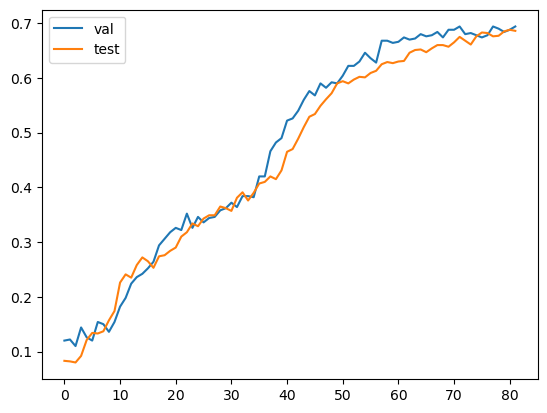

In [6]:
cora_best_model = train(Cora, device)

tensor(1.8171, device='cuda:0')
Epoch 1 train: 0.18445539474487305 val: 0.25 test: 0.1720000058412552
tensor(1.8173, device='cuda:0')
Epoch 2 train: 0.19759167730808258 val: 0.2120000123977661 test: 0.1720000058412552
tensor(1.8179, device='cuda:0')
Epoch 3 train: 0.1943076103925705 val: 0.20000000298023224 test: 0.1770000010728836
tensor(1.8058, device='cuda:0')
Epoch 4 train: 0.19321291148662567 val: 0.2240000069141388 test: 0.17800000309944153
tensor(1.7983, device='cuda:0')
Epoch 5 train: 0.20142309367656708 val: 0.22600001096725464 test: 0.1940000057220459
tensor(1.7903, device='cuda:0')
Epoch 6 train: 0.20853859186172485 val: 0.21000000834465027 test: 0.19500000774860382
tensor(1.7908, device='cuda:0')
Epoch 7 train: 0.19759167730808258 val: 0.20000000298023224 test: 0.20000000298023224
tensor(1.7856, device='cuda:0')
Epoch 8 train: 0.2019704431295395 val: 0.21400001645088196 test: 0.2240000069141388
tensor(1.7689, device='cuda:0')
Epoch 9 train: 0.20744389295578003 val: 0.202000

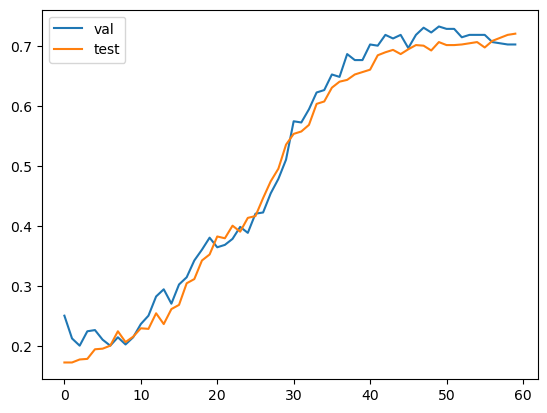

In [7]:
citeseer_best_model = train(CiteSeer, device)